<h1>Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


<h2>Featurizing text data with Tfidf word-vectors</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape

(404290, 6)

In [5]:
# Randomly selecting 100K datapoints

# We will collect different 100K rows without repetition from df dataframe
df = df.take(np.random.permutation(len(df))[:100000])
print(df.shape)
df.head(3)

(100000, 6)


,id,qid1,qid2,question1,question2,is_duplicate
309419,309419,90860,109342,What are the best Hollywood movies to watch in...,What were the best movies of 2016? Why?,0
25656,25656,47800,47801,What happened to people who believed in the 20...,What happened to people who sold off all their...,1
287493,287493,408276,408277,How does kinetic friction depend on the veloci...,Is the coefficient of kinetic friction velocit...,0


In [6]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [7]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [8]:
df1.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [9]:
df2.head(2)

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [10]:
df3.head(2)

,id
309419,309419
25656,25656


In [11]:
df1  = df1.merge(df2, on='id',how='left')

In [12]:
df1.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,...,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2>Check for NaN Rows</h2>

In [13]:
nan_rows = df1[df1.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 27 columns]


<h2>Final merged matrix</h2>

In [14]:
df  = df.merge(df1, on='id',how='left')

In [15]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,309419,90860,109342,What are the best Hollywood movies to watch in...,What were the best movies of 2016? Why?,0,0.999967,0.428565,0.399992,0.399992,...,14,68,39,12,8,4.0,20.0,0.200000,21,7
1,25656,47800,47801,What happened to people who believed in the 20...,What happened to people who sold off all their...,1,0.599988,0.374995,0.999980,0.499995,...,2,60,106,10,20,8.0,28.0,0.285714,3,1


In [16]:
df.to_csv('final_features.csv')

<h2>Random splitting the data</h2>

In [17]:
y_true = df['is_duplicate']
data = df.drop(['is_duplicate'],axis = 1)
from sklearn.model_selection import train_test_split
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.2)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 31), (20000, 31), (80000,), (20000,))

In [19]:
data.head(2)

,id,qid1,qid2,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,309419,90860,109342,What are the best Hollywood movies to watch in...,What were the best movies of 2016? Why?,0.999967,0.428565,0.399992,0.399992,0.624992,...,14,68,39,12,8,4.0,20.0,0.200000,21,7
1,25656,47800,47801,What happened to people who believed in the 20...,What happened to people who sold off all their...,0.599988,0.374995,0.999980,0.499995,0.799992,...,2,60,106,10,20,8.0,28.0,0.285714,3,1


In [20]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (80000, 31)
Number of data points in test data : (20000, 31)


<h2>Distribution of Yi's</h2>

In [21]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6316125 Class 1:  0.3683875
---------- Distribution of output variable in train data ----------
Class 0:  0.3684 Class 1:  0.3684


<h2>Confusion Matrix</h2>

In [22]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2>TFIDF Vectorization<h2>

In [23]:
tfidf = TfidfVectorizer(min_df = 3,ngram_range = (1,4),lowercase = False)
train_questions = X_train['question1'] + X_train['question2']
tfidf_train_feature = tfidf.fit_transform(train_questions)
test_questions = X_test['question1'] + X_test['question2']
tfidf_test_feature = tfidf.transform(test_questions)

# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
train_X = sc.fit_transform(tfidf_train_feature)
test_X = sc.transform(tfidf_test_feature)

In [24]:
train_X.shape

(80000, 202623)

In [25]:
y_train.shape

(80000,)

In [26]:
test_X.shape

(20000, 202623)

In [27]:
y_test.shape

(20000,)

<h2>Building a random model (Finding worst-case log-loss)</h2>

Log loss on Test Data using Random Model 0.883924379751209


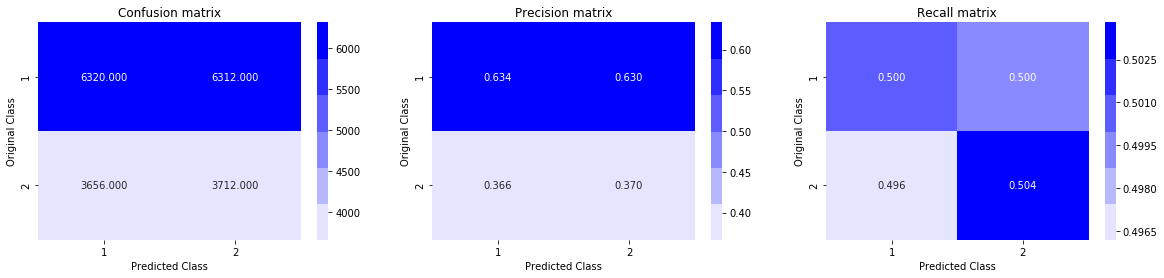

In [28]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h4>Random Model has a log-loss= 88.3%</h4>

<h2>Logistic Regression with hyperparameter tuning</h2>

For values of alpha =  1e-05 The log loss is: 0.5366667693860753
For values of alpha =  0.0001 The log loss is: 0.5365257548768713
For values of alpha =  0.001 The log loss is: 0.5371040973122108
For values of alpha =  0.01 The log loss is: 0.5375393880798718
For values of alpha =  0.1 The log loss is: 0.5213988076945169
For values of alpha =  1 The log loss is: 0.4876947590149828
For values of alpha =  10 The log loss is: 0.4849614678940293


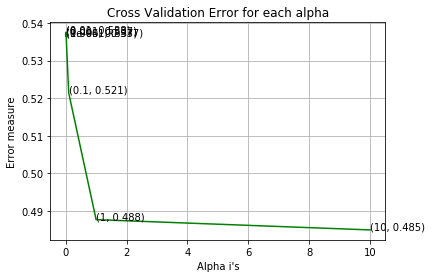

For values of best alpha =  10 The train log loss is: 0.3442263802327876
For values of best alpha =  10 The test log loss is: 0.4849614678940293
Total number of data points : 20000


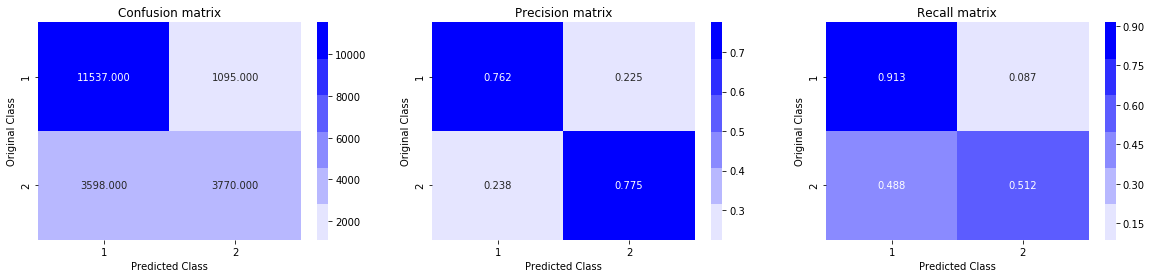

In [29]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=�hinge�, penalty=�l2�, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=�optimal�, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, �])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', class_weight = "balanced", random_state=42)
    clf.fit(train_X, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_X, y_train)
    predict_y = sig_clf.predict_proba(test_X)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', class_weight = "balanced", random_state=42)
clf.fit(train_X, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_X, y_train)

predict_y = sig_clf.predict_proba(train_X)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_X)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2>Linear SVM with hyperparameter tuning</h2>

For values of alpha =  1e-05 The log loss is: 0.5552340867123736
For values of alpha =  0.0001 The log loss is: 0.5827190503454709
For values of alpha =  0.001 The log loss is: 0.6223105014393636
For values of alpha =  0.01 The log loss is: 0.6533598321118876
For values of alpha =  0.1 The log loss is: 0.6575190451007379
For values of alpha =  1 The log loss is: 0.6580818697390208
For values of alpha =  10 The log loss is: 0.6580894755596748


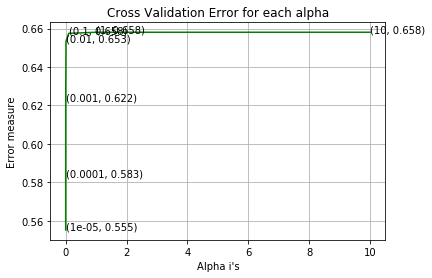

For values of best alpha =  1e-05 The train log loss is: 0.436449809544042
For values of best alpha =  1e-05 The test log loss is: 0.5552340867123736
Total number of data points : 20000


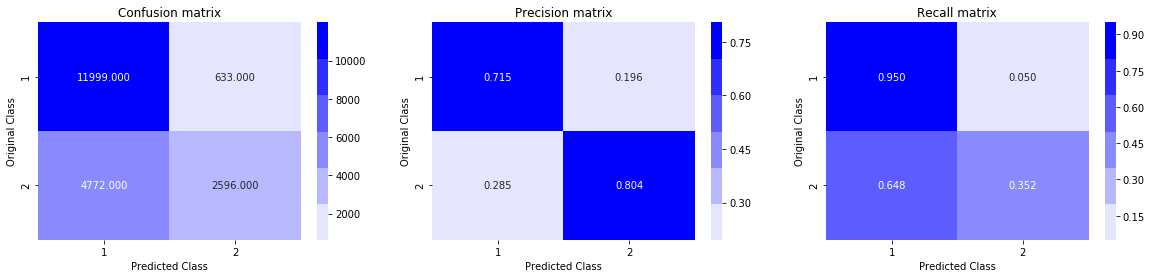

In [30]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=�hinge�, penalty=�l2�, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=�optimal�, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, �])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', class_weight = "balanced", random_state=42)
    clf.fit(train_X, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_X, y_train)
    predict_y = sig_clf.predict_proba(test_X)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', class_weight = "balanced", random_state=42)
clf.fit(train_X, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_X, y_train)

predict_y = sig_clf.predict_proba(train_X)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_X)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2>TFIDF-W2V Vectorization</h2>

<h2>Train Data</h2>

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [32]:
from tqdm import tqdm

In [33]:
import spacy
# conda install -c conda-forge spacy
# Right clik on the Anaconda Promt Icon
# Go to "More" and click on "Open as Administrator"
# Then type: python -m spacy download en
# python -m spacy download en_core_web_sm
# conda install -c anaconda msgpack-python
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')   # or   nlp = spacy.load('en')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1) , len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

100%|███████████████████████████████████████████████████████████████████████████| 80000/80000 [01:54<00:00, 696.00it/s]


In [34]:
X_train['q1_feats_m'] = list(vecs1)

In [35]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm') # or nlp = spacy.load('en')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question2'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1) , len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q2_feats_m'] = list(vecs1)

100%|███████████████████████████████████████████████████████████████████████████| 80000/80000 [02:12<00:00, 603.24it/s]


<h2>Test Data</h2>

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(X_test['question1']) + list(X_test['question2'])

tfidf.transform(questions)

<40000x51159 sparse matrix of type '<class 'numpy.float64'>'
	with 393735 stored elements in Compressed Sparse Row format>

In [37]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')  # or nlp = spacy.load('en')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1),len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_n'] = list(vecs1)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:33<00:00, 597.23it/s]


In [38]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')  # or nlp = spacy.load('en')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question2'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q2_feats_n'] = list(vecs1)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:32<00:00, 617.99it/s]


<h2>XGBoost (TFIDF)</h2>

In [69]:
import scipy.stats as sc
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
params = {"learning_rate":sc.uniform(0.02,0.1),
             "n_estimators":sc.randint(10,250),
             "max_depth":sc.randint(6,10),
             "min_child_weight":sc.randint(3,10),
              
        }
xgb_classifier = xgb.XGBClassifier(objective = 'binary:logistic')
grid = RandomizedSearchCV(xgb_classifier, params, cv = 3, scoring = "log_loss", verbose = 1, random_state = 0)
grid.fit(X_train,y_train)
print(grid.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 93.1min finished


{'learning_rate': 0.10579456176227568, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 221}


The train log loss is: 0.4228890260489701
/n The test log loss is: 0.4886763185456861
/n Total number of data points : 20000


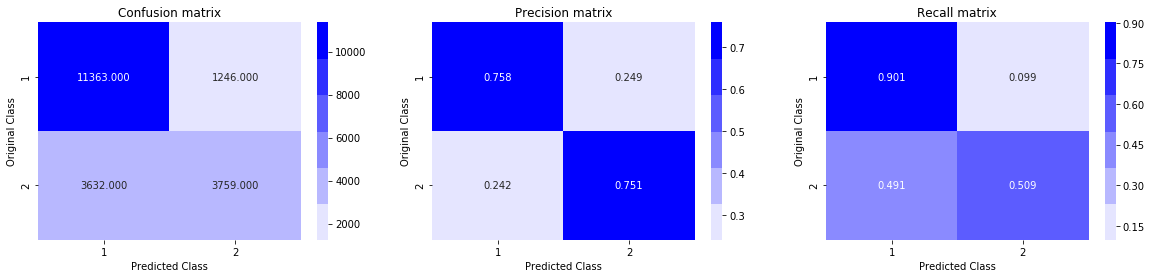

In [70]:
predict_y = grid.predict_proba(train_X)
print("The train log loss is:",log_loss(y_train, predict_y, eps=1e-15))
predict_y = grid.predict_proba(test_X)
print("/n The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("/n Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2>XGBoost (TFIDF W2V)</h2>

In [71]:
import scipy.stats as sc
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
params = {"learning_rate":sc.uniform(0.1,0.2),
             "n_estimators":sc.randint(3,100),
             "max_depth":sc.randint(3,7),
             "min_child_weight":sc.randint(1,4),
              
        }
xgb_classifier = xgb.XGBClassifier(objective = 'binary:logistic')
grid = RandomizedSearchCV(xgb_classifier, params, cv = 3, scoring = "log_loss", verbose = 1, random_state = 0)
grid.fit(X_train,y_train)
print(grid.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 170.4min finished


{'learning_rate': 0.27158912352455133, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 86}


The train log loss is: 0.21226851684236908
/n The test log loss is: 0.3323282824748902
/n Total number of data points : 20000


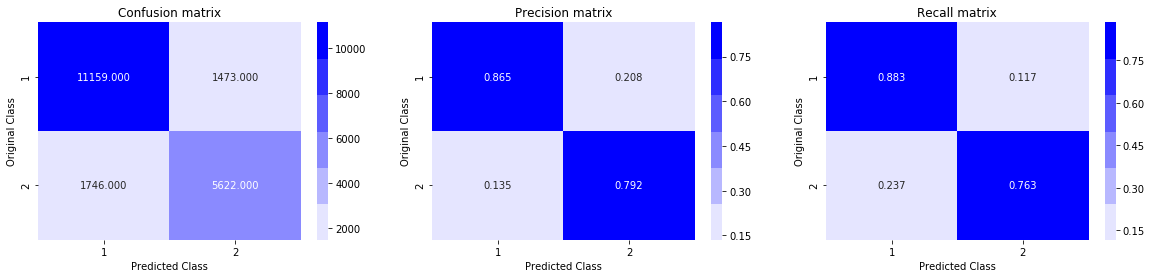

In [91]:
predict_y = grid.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y, eps=1e-15))
predict_y = grid.predict_proba(X_test)
print("/n The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("/n Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Conclusions
# Observation table

In [98]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ['Serial No.', 'Model Name', 'Tokenizer','Hyperparameter Tunning', 'Test Log Loss']
ptable.add_row(["1","Random","TFIDF","NA","0.88"])
ptable.add_row(["2","Logistic Regression","TFIDF","Done","0.48"])
ptable.add_row(["3","Linear SVM","TFIDF","Done","0.55"])
ptable.add_row(["4","XGBoost","TFIDF","Done","0.48"])
ptable.add_row(["5","XGBoost","TFIDF W2V","Done","0.33"])
print(ptable)

+------------+---------------------+-----------+------------------------+---------------+
| Serial No. |      Model Name     | Tokenizer | Hyperparameter Tunning | Test Log Loss |
+------------+---------------------+-----------+------------------------+---------------+
|     1      |        Random       |   TFIDF   |           NA           |      0.88     |
|     2      | Logistic Regression |   TFIDF   |          Done          |      0.48     |
|     3      |      Linear SVM     |   TFIDF   |          Done          |      0.55     |
|     4      |       XGBoost       |   TFIDF   |          Done          |      0.48     |
|     5      |       XGBoost       | TFIDF W2V |          Done          |      0.33     |
+------------+---------------------+-----------+------------------------+---------------+


# Procedure Followed:

STEP 1 : Preprocessing the data
    
STEP 2 : Featurizing text data with Tfidf word-vectors
    
STEP 3 : splitting the dataset
    
STEP 4 : Building a random model (Finding worst-case log-loss). It gave a log loss of 0.88%.This is the worst case log-loss. 
         Any model we design should have a log-loss lesser than this dumb model.
        
STEP 5 : After that we have applied Logistic Regression and hyperparameter tuned it. It gave a log-loss of 0.48, 
         which is significantly lower than Random Model. 
        
STEP 6 : After that we have applied Linear SVM and hyperparameter tuned it. It gave the log-loss of 0.55,
         which is significantly lower than Random Model.
        
STEP 7 : After that we have applied XGBoost on TFIDF W2V Vector and hyperparameter tuned it. It gave the log-loss of 0.33